In [4]:
from datetime import datetime
import os
import sys
sys.path.append('../')

import torch
from argparse import ArgumentParser
from glueDataHelper import InputBuilder
from torch.utils.data import DataLoader
from transformers import RobertaTokenizer, AdamW, get_linear_schedule_with_warmup, RobertaModel
from glueDataHelper import GlueDataset
from datasets import load_dataset
from utils import ModelManager, set_device
from models import ROBERTAOnSTS, ROBERTA_FT_MRPC
import trainModels
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from tqdm import tqdm, tqdm_notebook
tqdm.pandas()

In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device('cpu')
    print("CUDA is not available, using CPU...")

CUDA is not available, using CPU...


In [6]:
# Define Tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
max_len = 128

In [7]:
model = ROBERTA_FT_MRPC(ROBERTAOnSTS())

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
state_dict = torch.load('../models/MRPC_after_STS_model.pkl', map_location=torch.device('cpu'))
model.load_state_dict(state_dict['model_state_dict'])

<All keys matched successfully>

In [10]:
feature_extractor = InputBuilder(tokenizer, max_len)
model = model.eval()

In [15]:
CSV_PATH = "flickr30k_images/results.csv"
results = pd.read_csv(CSV_PATH,error_bad_lines=False,sep="|")
results.columns = [i.strip() for i in results.columns]
df = pd.DataFrame(results[['image_name','comment']],columns=['image_name','comment'])
df = df[:100]

In [16]:
query = 'two men'

In [17]:
def build_score(image_comments):
    l =  image_comments['comment'].tolist()
    scores = []
    for x in l:
        
        example = {
            'sentence1': query,
            'sentence2': x,
            'label' : 1
        }
        input_ids, input_mask, _ = feature_extractor.build_features(example)
        input_ids = input_ids.reshape(1, -1)
        input_mask = input_mask.reshape(1, -1)
        result = model(input_ids=input_ids.to(device), attention_mask=input_mask.to(device))
        result = result[0].detach().cpu()
        result = result[0].detach().cpu().numpy()[1] # just store how much it's likely to be similar
        scores.append(float(result))
    image_comments['score'] = [max(scores) for _ in range(len(l))]
    return image_comments[:1]

In [18]:
df_res = df.groupby("image_name").progress_apply(build_score)

100%|██████████| 20/20 [00:30<00:00,  1.52s/it]


In [19]:
df_res = pd.DataFrame(df_res[['image_name','score']],columns=['image_name','score'])
df_res = df_res.reset_index(drop=True)

In [20]:
df_res = df_res.sort_values(by=['score'], ascending=False)

In [23]:
IMAGES_PATH = 'flickr30k_images/flickr30k_images/'

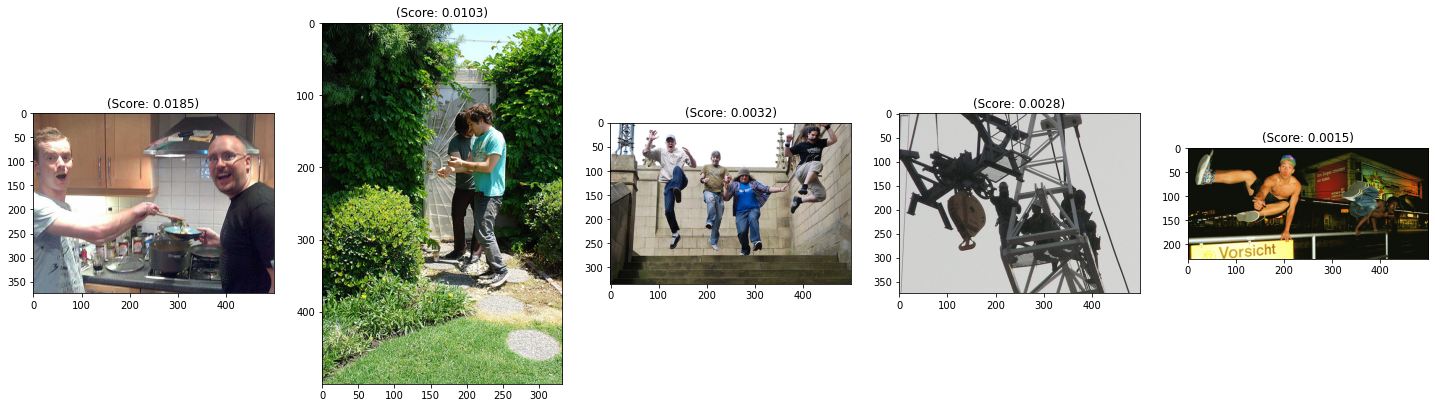

In [24]:
fig, axs = plt.subplots(1,5,figsize=(25, 20))
for ax, idx in zip(axs, [0, 1, 2, 3, 4]):
    img = mpimg.imread(IMAGES_PATH + df_res['image_name'].values[idx])
    ax.imshow(img)
    ax.set_title("(Score: {:.4f})".format(df_res['score'].values[idx]))

plt.show()